In [1]:
import tensorflow as tf

import os
import skimage.io as ski
import skimage.transform as skt
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from keras import Model



In [3]:
def import_MR1_Data():
    """
    Imports MRI data from the specified directory, resizes images, and returns
    the feature matrix (X) and corresponding labels (y).

    Returns:
    - numpy array (X): Feature matrix containing resized MRI images.
    - numpy array (y): Labels corresponding to the MRI image classes.

    Example:
    ```python
    X, y = import_MR1_Data()
    ```
    """
    import os
    import numpy as np
    import skimage.io as ski
    import skimage.transform as skt

    X = []  # Feature matrix containing MRI images
    y = []  # Labels corresponding to MRI image classes

    image_size = 160  # Size to which the images will be resized

    data_directory = "MRI1_Data/"  # Directory containing MRI data

    classes = os.listdir(data_directory)  # List of classes (subdirectories) in the data directory

    # Iterate through each class and its images
    for c in classes:
        folder = os.path.join(data_directory, c)
        for image in os.listdir(folder):
            # Load and resize the image
            load_image = ski.imread(os.path.join(folder, image))
            load_image = skt.resize(load_image, (image_size, image_size))

            # Append the resized image to the feature matrix (X)
            X.append(load_image)
            
            # Append the class label to the labels array (y)
            y.append(c)

    # Convert the feature matrix and labels to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y


In [4]:
X,y = import_MR1_Data()

In [21]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

# Further split the training set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [28]:
def map_categorical_to_integer(categorical_array, mapping):
    """
    Maps categorical labels to integer representations using a specified mapping.
    
    Parameters:
    - categorical_array (list or numpy array): An array containing categorical labels.
    - mapping (dict): A dictionary that associates categorical labels with integer values.

    Returns:
    - numpy array: An array of one-hot encoded vectors representing the mapped integer values.
    
    Example:
    ```python
    mapping = {"no_tumor": 0, "glioma_tumor": 1, "meningioma_tumor": 2, "pituitary_tumor": 3}
    labels = ["glioma_tumor", "pituitary_tumor", "no_tumor"]
    mapped_labels = map_categorical_to_integer(labels, mapping)
    ```
    """
    import tensorflow.keras.utils.to_categorical as to_categorical

    # Map categorical labels to integer values using the provided mapping dictionary
    for i in range(len(categorical_array)):
        categorical_array[i] = mapping[categorical_array[i]]

    # Convert the mapped integer labels to one-hot encoded vectors
    categorical_array = to_categorical(categorical_array)

    return categorical_array

In [22]:
# Create a mapping dictionary to associate categorical labels with integer values
mapping = {"no_tumor": 0, "glioma_tumor": 1, "meningioma_tumor": 2, "pituitary_tumor": 3}

# Map categorical labels to integer values for the training dataset
y_train = map_categorical_to_integer(y_train, mapping)

# Map categorical labels to integer values for the testing dataset
y_test = map_categorical_to_integer(y_test, mapping)

# Map categorical labels to integer values for the validation dataset
y_val = map_categorical_to_integer(y_val, mapping)



In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,                # Rescale pixel values to the range [0, 1]
    rotation_range=15,             # Random rotation (degrees)
    width_shift_range=0.1,         # Random horizontal shift
    height_shift_range=0.1,        # Random vertical shift
    shear_range=0.1,               # Shear intensity
    zoom_range=0.1,                # Random zoom
    horizontal_flip=True,          # Random horizontal flip
    vertical_flip=False,           # No vertical flip for MRI images
    fill_mode='nearest'            # Fill mode for handling newly created pixels
)

# Apply data augmentation to the training set
datagen.fit(X_train)

# Apply data augmentation to the test set
datagen.fit(X_test)

# Apply data augmentation to the validation set
datagen.fit(X_val)


In [8]:
base_model = MobileNet(include_top=False, input_shape=(160, 160, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = "relu")(x)
x = Dense(64, activation = "relu")(x)
preds = Dense(4,activation = "softmax")(x)

In [9]:
model_mobilenet = Model(inputs = base_model.input, outputs=preds)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model_mobilenet.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [10]:
history = model_mobilenet.fit(train_X, train_y, epochs = 10, validation_data = (test_X, test_y))

Epoch 1/10


74/74 [==============================] - 112s 1s/step - loss: 0.6811 - accuracy: 0.7396 - val_loss: 0.7008 - val_accuracy: 0.7058
Epoch 2/10
74/74 [==============================] - 96s 1s/step - loss: 0.2722 - accuracy: 0.9072 - val_loss: 0.5307 - val_accuracy: 0.8112
Epoch 3/10
74/74 [==============================] - 101s 1s/step - loss: 0.1507 - accuracy: 0.9562 - val_loss: 0.5631 - val_accuracy: 0.7687
Epoch 4/10
74/74 [==============================] - 101s 1s/step - loss: 0.0828 - accuracy: 0.9796 - val_loss: 0.3622 - val_accuracy: 0.8707
Epoch 5/10
74/74 [==============================] - 152s 2s/step - loss: 0.0475 - accuracy: 0.9919 - val_loss: 0.4741 - val_accuracy: 0.8146
Epoch 6/10
74/74 [==============================] - 135s 2s/step - loss: 0.0315 - accuracy: 0.9949 - val_loss: 0.2209 - val_accuracy: 0.9337
Epoch 7/10
74/74 [==============================] - 137s 2s/step - loss: 0.0204 - accuracy: 0.9974 - val_loss: 0.1716 - val_accuracy: 0.9473
Epoch 8/10
7

In [11]:
model_mobilenet.evaluate(x = val_X, y = val_y)


11/11 [==============================] - 5s 414ms/step - loss: 0.2087 - accuracy: 0.9266


[0.20869803428649902, 0.9266055226325989]

# Loading and testing model on a different brain tumor dataset

In [12]:
new_dataset_X = []
new_dataset_y = []

image_size = 160

data_directory = "MRI2_Data/"

for c in classes:
    folder = os.path.join(data_directory, c)
    for image in os.listdir(folder):
        load_image = ski.imread(os.path.join(folder,image))
        load_image = skt.resize(load_image, (image_size,image_size))
        new_dataset_X.append(load_image)
        new_dataset_y.append(c)

new_dataset_X = np.array(X)
new_dataset_y = np.array(y)

print("Dataset loaded")

new_dataset_y_new = []
for i in new_dataset_y:
    new_dataset_y_new.append(classes.index(i))
new_dataset_y = new_dataset_y_new
new_dataset_y = tf.keras.utils.to_categorical(new_dataset_y)

idg.fit(new_dataset_X)

model_mobilenet.evaluate(x = new_dataset_X, y = new_dataset_y)

Dataset loaded
103/103 [==============================] - 35s 325ms/step - loss: 0.0536 - accuracy: 0.9844


[0.05358712002635002, 0.984379768371582]

In [13]:
import h5py

new2_X = []
new2_y = []
new2_y2d = []

data_directory = "matlab_files/"

for folder in os.listdir(data_directory):

    folder_directory = os.path.join(data_directory,folder)

    for mat_file in os.listdir(folder_directory):
        file = h5py.File(os.path.join(folder_directory,mat_file), 'r')

        load_label = file['cjdata']["label"][0][0]
        
        if load_label == 1:
            new2_y.append("meningioma_tumor")
        elif load_label == 2:
            new2_y.append("glioma_tumor")
        elif load_label == 3:
            new2_y.append("pituitary_tumor")
        else:
            new2_y.append("no_tumor")   

        load_tumorMask = np.array(file["cjdata"]["tumorMask"])

        load_image = np.array(file["cjdata"]['image'])

        resize_image = skt.resize(load_image, (image_size,image_size))
        resize_tumorMask = skt.resize(load_tumorMask, (image_size,image_size))

        new2_X.append(resize_image)
        new2_y2d.append(resize_tumorMask)


c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


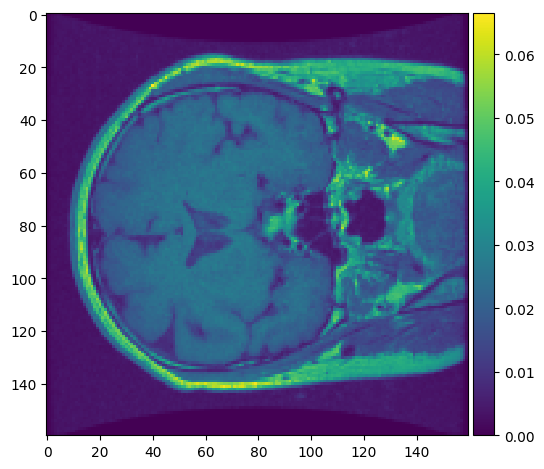

In [14]:
from skimage.io import imshow
imshow(new2_X[0])

In [45]:
import cv2

backtorgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

ModuleNotFoundError: No module named 'cv2'

In [46]:
new2_X = np.array(new2_X)
new2_y = np.array(new2_y)

print("Dataset loaded")

new2_y_new = []
for i in new2_y:
    new2_y_new.append(classes.index(i))
new2_y = new2_y_new
new2_y = tf.keras.utils.to_categorical(new2_y)

idg.fit(new2_X)

model_mobilenet.evaluate(x = new2_X, y = new2_y)

Dataset loaded


KeyboardInterrupt: 

In [ ]:
idg.fit(new2_X)

model_mobilenet.evaluate(x = new2_X, y = new2_y)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (3064, 160, 160)

In [29]:
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Transfer Learning
Transfer learning is a machine learning technique where a pre-trained model, developed on a large dataset for a specific task, is reused as the starting point for a different but related task. 

The primary benefit of using transfer learning is that it allows a model to leverage knowledge gained from training on one task (usually a large dataset) and apply that knowledge to another related task. This is particularly advantageous when the new task has a limited amount of labeled data, as transfer learning can lead to faster convergence, improved generalization, and enhanced performance compared to training a model from scratch. Transfer learning is especially prevalent in deep learning applications, where pre-trained models on large datasets (e.g., ImageNet for image classification) serve as effective feature extractors for various downstream tasks.

Due to the limited amount of labeled data to train the model on, we will use transfer learning in our modelling. The models that we will attempt to implement are:
- VGG16 and VGG19
- ResNet
- Inception
- DenseNet
- MobileNet
- EfficientNet
- Xception


## The Concept of Freezing
In the context of deep learning, "freezing" refers to the practice of fixing the weights of certain layers in a neural network during the training process. When a layer is frozen, its weights are not updated or adjusted during backpropagation. This can be beneficial in various scenarios, especially when using pre-trained models or transfer learning.

When a pre-trained model is used as the starting point for a new task, freezing layers is a strategic choice that offers several advantages:

1. Retaining Pre-trained Knowledge:
> The lower layers of a deep neural network often learn generic, low-level features such as edges, textures, and basic patterns. These features are applicable across a wide range of tasks. By freezing these lower layers, you retain the pre-trained knowledge, allowing the model to leverage representations that are likely to be useful for the new task.

2. Avoiding Overfitting on Limited Data:
> When the new task has a limited amount of labeled data, there is a risk of overfitting if the model is allowed to update its parameters too much. Freezing layers prevents the model from adapting too much to the small dataset, reducing the risk of overfitting.
3. Reducing Training Time and Resource Usage:
> The training of deep neural networks, especially with large architectures, can be computationally expensive. By freezing layers, you reduce the number of parameters that need to be updated during each training iteration, leading to faster training times and reduced resource requirements.
Freezing the layers from the imported mobile net and only fitting the input layer + the layers we are adding. We do this because the model has already been pre-trained and we are only fitting it to our additions to the model which are the input layer, the pooling layer, and the densed layers.

We will be freezing the layers from the pre-trained transfer models and only fitting the layers we are adding to the transfer model to accomodate for the parameters of our data set.

## Transfer Model Implementation - VGG16 and VGG19
VGG16 and VGG19 are deep convolutional neural network architectures introduced by the Visual Geometry Group at Oxford University. VGG16 consists of 16 layers, including 13 convolutional layers and 3 fully connected layers, with small 3x3 convolutional filters. VGG19 extends this architecture to 19 layers, offering increased expressiveness but with a trade-off in terms of computational complexity. Both models are known for their simplicity and effectiveness in image classification tasks, with VGG16 achieving competitive performance on benchmarks like ImageNet.

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,                # Rescale pixel values to the range [0, 1]
    rotation_range=15,             # Random rotation (degrees)
    width_shift_range=0.1,         # Random horizontal shift
    height_shift_range=0.1,        # Random vertical shift
    shear_range=0.1,               # Shear intensity
    zoom_range=0.1,                # Random zoom
    horizontal_flip=True,          # Random horizontal flip
    vertical_flip=False,           # No vertical flip for MRI images
    fill_mode='nearest'            # Fill mode for handling newly created pixels
)

train_generator = datagen.flow_from_directory(
    'Kaggle_DataSet1/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical' 
)

val_generator = datagen.flow_from_directory(
    'Kaggle_DataSet1/Val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    'Kaggle_DataSet1/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  
)

Found 2283 images belonging to 4 classes.
Found 330 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


In [34]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models


# Load the pre-trained VGG16 model without the fully connected layers
VGG16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in VGG16_base_model.layers:
    layer.trainable = False

# Create a new model by adding custom fully connected layers on top of the VGG16 base
VGG16_transfer_model = models.Sequential()
VGG16_transfer_model.add(VGG16_base_model)
VGG16_transfer_model.add(layers.Flatten())
VGG16_transfer_model.add(layers.Dense(512, activation='relu'))
VGG16_transfer_model.add(layers.Dropout(0.5))
VGG16_transfer_model.add(layers.Dense(256, activation='relu'))
VGG16_transfer_model.add(layers.Dropout(0.5))
VGG16_transfer_model.add(layers.Dense(4, activation='softmax'))  

# Compile the model
VGG16_transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the data generator
VGG16_history = VGG16_transfer_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

VGG16_validation_score = VGG16_transfer_model.evaluate(val_generator)



Epoch 1/10
11/72 [===>..........................] - ETA: 9:42 - loss: 4.7587 - accuracy: 0.2784

KeyboardInterrupt: 

In [ ]:
# Save the model to a file
from tensorflow.keras.models import save_model

VGG16_transfer_model.save('VGG16_transfer_model.h5')

# To reload the model use:
# from tensorflow.keras.models import load_model

# # Load the model
# VGG16_transfer_model = load_model('VGG16_transfer_model.h5')

In [24]:
transfer_model = MobileNet(include_top=False, input_shape=(160, 160, 3))
x = transfer_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = "relu")(x)
x = Dense(64, activation = "relu")(x)
outputs = Dense(4,activation = "softmax")(x)
mobilenet_transfer_model = Model(inputs = transfer_model.input, outputs=outputs)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
mobilenet_transfer_model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [25]:
# Input layer
input_layer = mobilenet_transfer_model.layers[0]
# Imported transfer model layers
transfer_layers = mobilenet_transfer_model.layers[1:-4]
# Pooling layer
pooling_layer = mobilenet_transfer_model.layers[-4]
# Dense layers
dense_layers = mobilenet_transfer_model.layers[-3:]

In [26]:
# Freeze the transfered layers
for layer in transfer_layers:
    layer.trainable = False

In [27]:
history = mobilenet_transfer_model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
74/74 [==============================] - 211s 3s/step - loss: 0.6468 - accuracy: 0.7498 - val_loss: 0.9745 - val_accuracy: 0.6310
Epoch 2/10
74/74 [==============================] - 128s 2s/step - loss: 0.2318 - accuracy: 0.9311 - val_loss: 0.5065 - val_accuracy: 0.8129
Epoch 3/10
74/74 [==============================] - 113s 2s/step - loss: 0.1113 - accuracy: 0.9728 - val_loss: 0.7634 - val_accuracy: 0.7177
Epoch 4/10
74/74 [==============================] - 118s 2s/step - loss: 0.0642 - accuracy: 0.9898 - val_loss: 0.5942 - val_accuracy: 0.8095
Epoch 5/10
74/74 [==============================] - 107s 1s/step - loss: 0.0363 - accuracy: 0.9953 - val_loss: 0.5098 - val_accuracy: 0.8282
Epoch 6/10
74/74 [==============================] - 111s 2s/step - loss: 0.0232 - accuracy: 0.9974 - val_loss: 0.3178 - val_accuracy: 0.8895
Epoch 7/10
74/74 [==============================] - 113s 2s/step - loss: 0.0217 - accuracy: 0.9957 - val_loss: 0.2314 - val_accuracy: 0.9303
Epoch 8/10
74

In [30]:
mobilenet_transfer_model.evaluate(X_val, y_val)

11/11 [==============================] - 5s 394ms/step - loss: 0.1785 - accuracy: 0.9450


[0.17845046520233154, 0.9449541568756104]